# Project 1: Interpolation with Autoregressive (AR) Model
# Solution
## Deniz Ekiz, 2016700051

- Read the flights.csv file into two column vectors T and X, where X is partially observed
monthly totals of international airline passengers and T is the corresponding months.
Plot T vs. X.

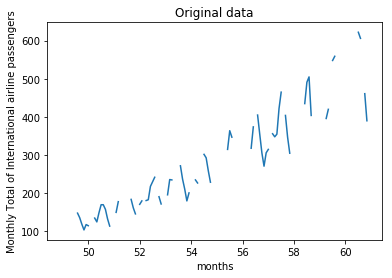

In [108]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

my_data = np.genfromtxt('flights.csv', delimiter=',')
my_data = my_data[1:,]
T = my_data[:,0]
X = my_data[:,1]
#print X
plt.plot(T -1900,X)
plt.xlabel('months')
plt.ylabel('Monthly Total of International airline passengers')
plt.title('Original data')
plt.show()
X_mi_sel = np.isnan(X)
#X = np.nan_to_num(X)
#print X_mi
#np.where(np.invert(X_mi_sel))
#for i in range(0,len(X_mi_sel)):
#    if X_mi_sel[i]:
#        X[i] = 999

- Iteratively construct $G_X$ and solve for A 
- then fix A construct $G_A$ and solve for $X^{mi}$ by least
squares (Alternating Least Squares). 

$G_A(X^{obs} + X^{mi}) = \epsilon$

$G_AX^{mi}=\epsilon -  G_AX^{obs}  $


You can choose M = 4.

Fix X

Compute

$A =  (G_X^TG_X)^{-1}(G_X^TG_X)$.

Fix A
Remove the 0 rows of Xi, and corresponding columns of Ga.

Solve

$X^{mi} = -1(G_A^TG_A)^{-1}(G_A^TG_AX^{ob})$.

Update

$X = X^{mi}$

Select M = 4

I solved the problem with  SVD least square, QR least square and  normal equation.

In [109]:
#Creates Gx
M = 4
T = my_data[:,0]
X = my_data[:,1]

#creates Xmi
def Xmi(X):
    T = np.copy(X)
    for i in range(0,len(X_mi_sel)):
        if not X_mi_sel[i]:
            T[i] = 0
    return T
#creates Xobs
def Xobs(X):
    T = np.copy(X)
    for i in range(0,len(X_mi_sel)):
        if X_mi_sel[i]:
            T[i] = 0
    return T

def G_x(X_a,shape):
    Gxx = np.zeros((shape-M,M))
    for i in range(M,shape):
        for m in range(0,M):
            Gxx[i-M,m] = np.copy(X_a[i-(m+1)])
    return Gxx;

#Creates Ga, from X and shape
def G_a(X_b,shape):
    Gaa = np.zeros((shape,shape+M))
    #Gaa.shape = (shape,shape+4)
    for i in range(0,shape):
        for m in range(0,M):
            Gaa[i,m+i] = np.copy(X_b[m])
        Gaa[i,M+i] = -1
    return Gaa;
def norm_lsq(A,b):
    A_t_A = np.dot(A.conj().transpose(),A)
    A_t_b = np.dot(A.conj().transpose(),b)
    return np.linalg.solve(A_t_A,A_t_b)
def svd_lsq(A,b):
    #Compute Reduced SVD
    U, E, V_T = np.linalg.svd(A, full_matrices=False)
    V = V_T.conj().transpose()
    e = np.diag(E)
    u_T_b = np.dot(U.conj().transpose(),b)
    m = np.linalg.solve(e,u_T_b)
    sol = np.dot(V,m)
    return sol
def qr_lsq(A,b):
    q, r = np.linalg.qr(A)
    q_T_b = np.dot(q.conj().transpose(),b)
    return np.linalg.solve(r,q_T_b)
    
#Deletes the nan values
def nan_to_mean(X,j):
    T = np.copy(X)
    mean = np.mean(X[~np.isnan(X)])
    for i in range(j,len(X_mi_sel)):
            #if X_mi_sel[i]:
        if np.isnan(T[i]):
            #T[i] = np.copy(T[i-1])
            T[i] = np.random.randn()*600
    #print "T\n",T
    return T
X_mi = np.zeros(144)
X_obs_i = np.copy(np.nan_to_num(X))
#OO = np.copy(nan_to_mean(X,0))
for j in range(0,100):
    Gx = G_x(X,144)
    LL = np.nan_to_num(X)
    sample = G_x(np.copy(np.nan_to_num(X)),144)
    # First Least Square
    A_i = svd_lsq(sample,LL[M:].T)
    #A_i = norm_lsq(sample,LL[M:])
    #A_i = qr_lsq(sample,LL[M:])
    #A_i = np.linalg.lstsq(sample,LL[M:])
    #Check if A_i converge
    print A_i
    #Create Ga
    Ga = G_a(A_i,144-M)
    X_mi = Xmi(X)
    #print X_mi
    X_mi_n = np.array([])
    X_obs_n = np.array([])
    Ga_n = np.array([])
    Ga_obs_n = np.array([])
    for i in range(0,len(X_mi)):
        if X_mi[i] != 0:
            X_mi_n = np.concatenate((X_mi_n,[X_mi[i]]))
            if len(Ga_n)>0:
                Ga_n = np.column_stack((Ga_n,Ga[:,i]))
            else:
                Ga_n = Ga[:,i]
        else:
            X_obs_n = np.concatenate((X_obs_n,[X_obs_i[i]]))
            if len(Ga_obs_n)>0:
                Ga_obs_n = np.column_stack((Ga_obs_n,Ga[:,i]))
            else:
                Ga_obs_n = Ga[:,i]
    ###Solve GaX_obs ~ GaX_mi
    #Create Ga_xObs
    Ga_X_obs = np.dot(-1,np.dot(Ga_obs_n,X_obs_n.T))
    #print Ga_n
    #print X_mi_n
    #print X_mi_n
    #print X_obs_i
    #Solve GaX_obs ~ GaX_mi via Least Squares
    X_mi_n = svd_lsq(Ga_n,Ga_X_obs)
    #X_mi_n = norm_lsq(Ga_n,w)
    #X_mi_n = qr_lsq(Ga_n,w)
    #X_mi_n = np.linalg.lstsq(a= Ga_n,b=w)[0]
    #print X_mi
    #print len(X_mi)
    z = 0
    for i in range(0,len(X_mi)):
        if X_mi[i] != 0:
            X_mi[i] = X_mi_n[z]
            z = z+1
    X = np.sum([Xmi(X_mi),Xobs(X)],axis=0)
#print X
#print LL
#print "X_obs",X_obs_i
#print "X", X
#print Gx

[ 0.2150142   0.20981954  0.41332953  0.00110816]
[ 0.55050974  0.29349306  0.06428895  0.09514406]
[ 0.39275649  0.0397901   0.17301882  0.41067861]
[ 0.86558554 -0.11501238 -0.0277837   0.28670114]
[ 0.60655    -0.10337547  0.04628279  0.46756083]
[ 0.89856239 -0.23549801  0.0086736   0.33984581]
[ 0.70714683 -0.13450604 -0.00559792  0.4487533 ]
[ 0.8437478  -0.22799921  0.02922251  0.36806009]
[ 0.74737392 -0.14830627 -0.01442023  0.43024256]
[ 0.81048656 -0.20930172  0.02674768  0.38576983]
[ 0.76685587 -0.16023176 -0.0107553   0.41859053]
[ 0.79445713 -0.19618978  0.01987245  0.39586076]
[ 0.77651415 -0.16916184 -0.00492356  0.41184135]
[ 0.78719868 -0.18824729  0.01395048  0.40122347]
[  7.80938188e-01  -1.74761910e-01  -2.30318573e-04   4.08248592e-01]
[ 0.78418672 -0.18387296  0.01001121  0.40384604]
[ 0.78271061 -0.17782342  0.00275991  0.40652255]
[ 0.78311268 -0.18167611  0.00773875  0.40500814]
[ 0.78327438 -0.17931135  0.0044116   0.40579028]
[ 0.78284052 -0.18067929  0.00

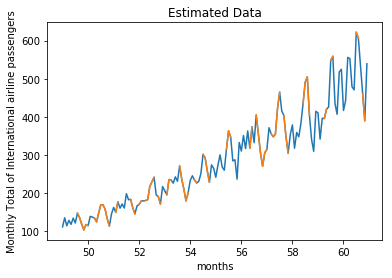

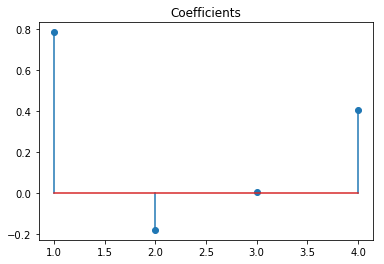

In [110]:
%matplotlib inline
z = 0
#print LL
#print X_mi
#plt.plot(T[M:] -1900,np.sum([X_mi[M:],X_obs_i[M:]],axis=0))
plt.plot(T -1900,X)
#plt.plot(T[M:] -1900,OO[M:])
#plt.plot(T[M:] -1900,FF)
plt.plot(T -1900,my_data[:,1])
plt.xlabel('months')
plt.ylabel('Monthly Total of International airline passengers')
plt.title('Estimated Data')
plt.show()
fig, ax = plt.subplots()
ax.stem(range(1,M+1),A_i)
plt.title('Coefficients')
plt.show()
#print np.dot(Ga.T,Ga)
#RR = np.dot(Ga.T,Ga)
#print np.linalg.inv(RR)
#print X_mi_sel
#print X_mi.T + X_obs.T
#print  X_mi
#print X_obs_i
#print np.sum([X_mi,X_obs_i],axis=0)

# Project 1 Bonus

Assume X is fully observed, then we can write following system of linear equations:
$
\begin{bmatrix}
    X_{M} \\
    X_{M+1}   \\
    \vdots  \\
    X_{N}  
\end{bmatrix}
=
\begin{bmatrix}
    X_{M-1} & X_{m-2} &\dots & X_{0}  & T_{M} & 1\\
    X_{M} & X_{M-1} & \dots   & X_{1} & T_{M+1} & 1\\
    \vdots & \vdots & \ddots  & \vdots & \vdots & \vdots\\
    X_{N-1} & X_{N-2} & \dots   & X_{N-M} & T_{N} & 1
\end{bmatrix}
\begin{bmatrix}
    A_{1} \\
    A_{2}   \\
    \vdots  \\
    A_{M}  \\
    C \\
    D
\end{bmatrix}
+
\begin{bmatrix}
    \epsilon_{M} \\
    \epsilon_{M+1}   \\
    \vdots  \\
    \vdots  \\
    \vdots \\
    \epsilon_{N}
\end{bmatrix}$

which we will be denoted by $X_{M:N} = G_XA + \epsilon$. Similarly, if we assume A is known, hopefully we know all of the T's.

$\begin{bmatrix}
    \epsilon_{M} \\
    \epsilon_{M+1}   \\
    \vdots  \\
    \vdots  \\
    \epsilon_{N-1}\\
    \epsilon_{N}
\end{bmatrix}
=
\begin{bmatrix}
    A^{T} & -1 & 0 & 0 & \dots  &  0\\
    0 & A^{T} & -1   & 0 &\dots  & 0\\
    \vdots & \ddots & \ddots  & \ddots & -1 & 0 \\
    0 & \dots & 0   & 0 & A^{T} & -1
\end{bmatrix}
\begin{bmatrix}
    X_{0} \\
    X_{1}   \\
    \vdots  \\
    X_{N-1} \\
    X_N
\end{bmatrix}
+
\begin{bmatrix}
    T_{M} & 1\\
    T_{M+1}& 1 \\
    \vdots \\
    T_{N} & 1
\end{bmatrix}
$
$
\begin{bmatrix}
    C\\
    D
\end{bmatrix}
$

If we solve the equation above we will have a better estimate. 
$-G_{A}X^{obs} - G_{T}  \sim G_AX^{mi} $ 

In [111]:
X = my_data[:,1]
T = my_data[:,0]
X_mi = np.zeros(144)
X_obs_i = np.copy(np.nan_to_num(X))
for i in range(0,500):
    if i == 0:
        LL = np.copy(np.nan_to_num(X))
    else:
        LL = X
    Gx = G_x(LL,144)
    Gx = np.column_stack((Gx,T[M:].T))
    Gx = np.column_stack((Gx,np.ones(144-M).T))
    A_i = svd_lsq(Gx,LL[M:])
    Ga = G_a(A_i[:M],144-M)
    w = np.dot(-1,np.dot(Ga,X_obs_i))
    X_mi = Xmi(X)
    #print X_mi
    X_mi_n = np.array([])
    Ga_n = np.array([])
    for i in range(0,len(X_mi)):
        if X_mi[i] != 0:
            X_mi_n = np.concatenate((X_mi_n,[X_mi[i]]))
            if len(Ga_n)>0:
                Ga_n = np.column_stack((Ga_n,Ga[:,i]))
            else:
                Ga_n = Ga[:,i]
    #Ga_n = G_a(X_mi_n,len(X_mi_n)-M)
    #print Ga_n.shape
    #print X_mi_n
    X_mi_n = np.copy(np.nan_to_num(X_mi_n))
    #print A_i
    X_mi_n = svd_lsq(Ga_n,np.sum([w,np.dot(-1,np.dot(Gx[:,-2:],A_i[-2:].T))],axis=0 ))
    #print len(X_mi_n)
    #X = X_mi
    z = 0
    for i in range(0,len(X_mi)):
        if X_mi[i] != 0:
            X_mi[i] = X_mi_n[z]
            z = z+1
    X = np.sum([Xmi(X_mi),Xobs(X)],axis=0)
#print X
#print LL
#print "X_obs",X_obs_i
#print "X", X
#print Ga_n

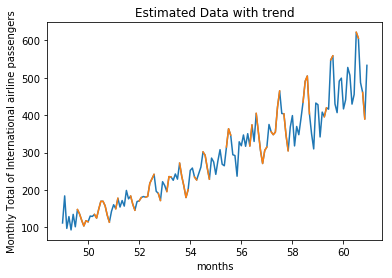

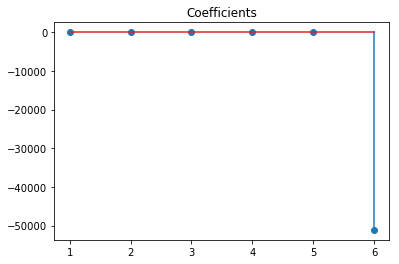

In [113]:
%matplotlib inline
z = 0
#print LL
#print X_mi
#plt.plot(T[M:] -1900,np.sum([X_mi[M:],X_obs_i[M:]],axis=0))
plt.plot(T -1900,X)
#plt.plot(T[M:] -1900,OO[M:])
#plt.plot(T[M:] -1900,FF)
plt.plot(T -1900,my_data[:,1])
plt.xlabel('months')
plt.ylabel('Monthly Total of International airline passengers')
plt.title('Estimated Data with trend')
plt.show()
fig, ax = plt.subplots()
ax.stem(range(1,M+3),A_i)
# coefficients are A_{1:M}, C,D
plt.title('Coefficients')
plt.show()

# Project 2 Image Segmentation with Spectral Clustering

- Read the stones rgb.jpg into a tensor $X ∈ R^{64×64×3}$ where the color intensity of channel
c (red, green, or blue) at pixel $(x, y)$ is denoted by $X_{xyc}$ (see: imread). Then, plot the
image (see: imshow).

Shape of X is  (64, 64, 3)


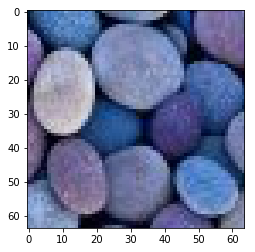

In [116]:
import scipy.misc as spc
import scipy.linalg as spl
import numpy as np
import math
X = spc.imread("stones_rgb.jpg")
print "Shape of X is ", X.shape
plt.imshow(X)
#first k eigenvector
k = 5

In [132]:
h = len(X)
n = h*h
r,sigma = 2.0,10.0
E = np.array([[ 0.299,0.587,0.114],[-0.14713,-0.28886,0.436],[0.615,-0.51499,-0.10001],])

In [ ]:
def sim(i, j):
    xi,xj = i%h,j%h
    yi,yj = (i-xi)/h,(j - xj)/h
    if i == j or abs(xi - xj)>r or abs(yi - yj)>r:
        return 0
    ci = X[xi, yi]
    cj = X[xj, yj]
    ci_minus_cj = np.sum([ci , np.dot(-1,cj)],axis=0)
    dist = np.sum(np.dot(ci_minus_cj.T,np.dot(E,ci_minus_cj)))
    return np.exp(-1*dist/(2*sigma**2))

In [133]:
# Construct W
W = np.ones((n,n))
for i in range(n):
    for j in range(0, n):
        W[i, j] = sim(i, j)
#Check if Wij = Wji
print W[1,3]
print W[3,1]

1.90575822926
1.90575822926


In [134]:
# Compute the sum of each row
D = np.sum(W, axis=1) 
#Create diagonal matrix
D = np.diag(D)
D_inv_sqrt = np.linalg.inv(np.sqrt(D))
#Laplacian matrix
L = np.dot(np.dot(D_inv_sqrt,W),D_inv_sqrt)

In [146]:
k=5
[Q,R] = np.linalg.qr(np.random.randn(n,k),mode='reduced')
for i in range(2000):
    Z = np.dot(L,Q);
    [Q, R] = np.linalg.qr(Z,mode='reduced');

In [181]:
V = np.dot(D_inv_sqrt,Q)
np.set_printoptions(suppress=True)
print R
ls


[[ 0.9999  0.     -0.     -0.0001  0.0002]
 [ 0.      0.9999 -0.0002 -0.     -0.0001]
 [ 0.      0.      0.9998  0.0001 -0.0002]
 [ 0.      0.      0.      0.9997  0.0003]
 [ 0.      0.      0.      0.      0.9997]]


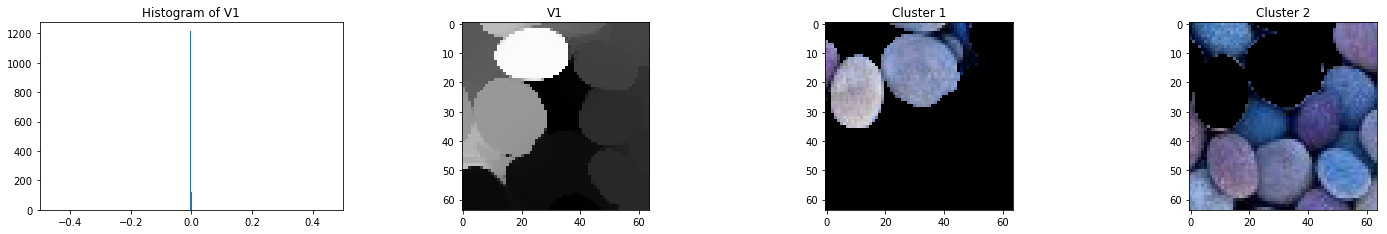

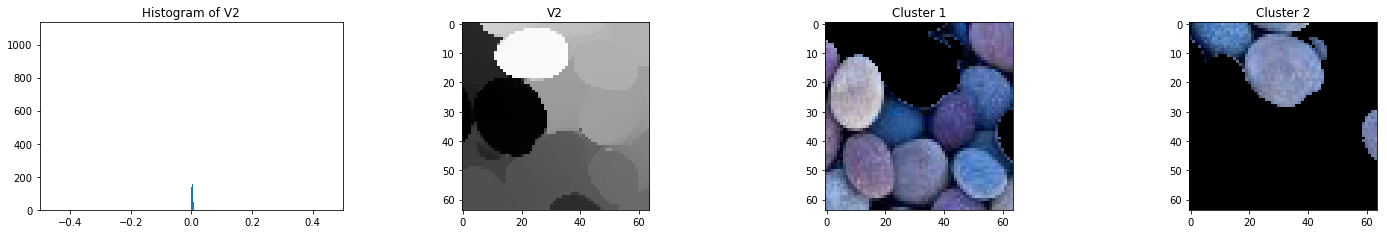

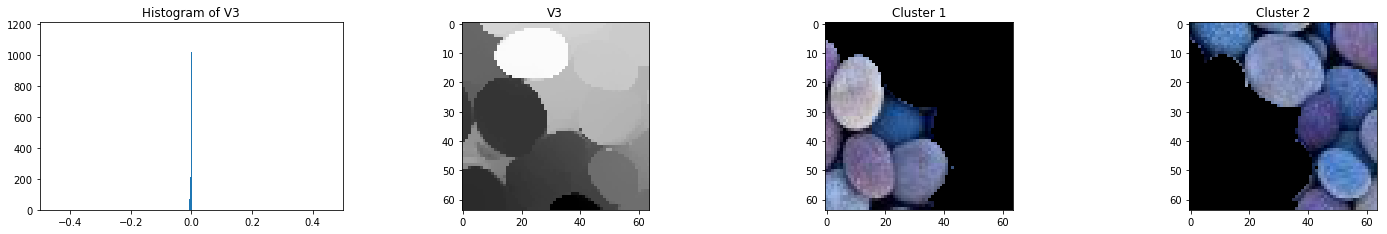

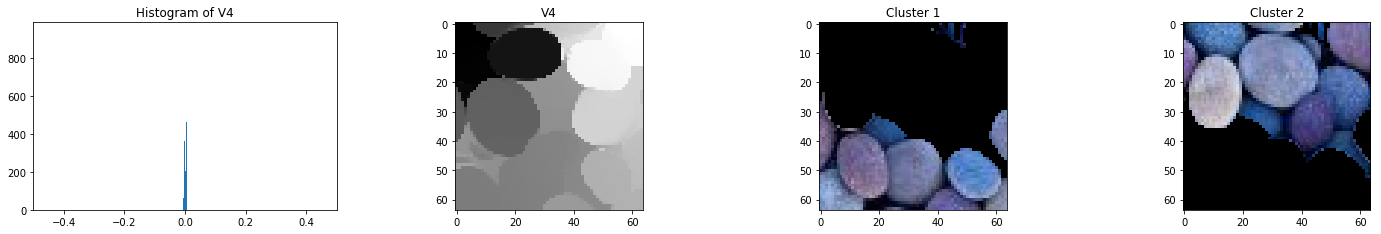

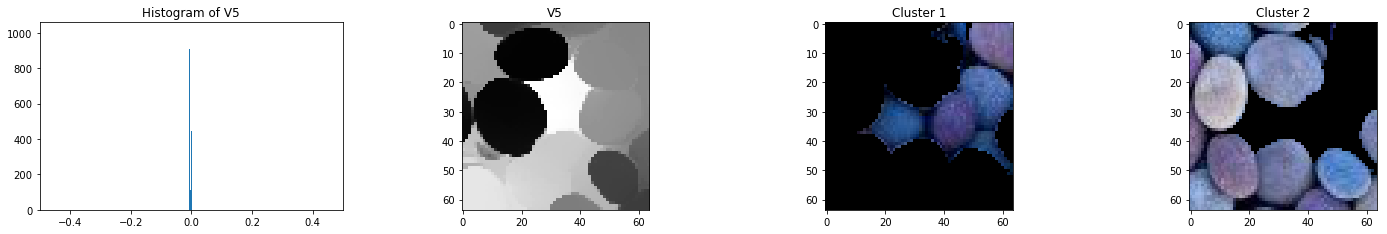

In [194]:
for i in range(k):
    plt.figure(figsize=(25, 20))
    plt.subplot(k, 4, i*4 + 1)
    v = V[:, i]
    plt.hist(v)
    plt.title('Histogram of V' + str(i + 1))
    axes = plt.gca()
    axes.set_xlim([-0.5,0.5])
    plt.subplot(k, 4, i*4 + 2)
    plt.imshow(v.reshape(h, h), cmap='gray')
    plt.title('V' + str(i + 1))
    cls1,cls2 = np.copy(X),np.copy(X)
    for x in range(h):
        for y in range(h):
            if v[x+(y)*h] < 0:
                cls1[x, y] = 0
            else:
                cls2[x, y] = 0
    plt.subplot(k,4,i*4+3)
    plt.imshow(cls1)
    plt.title('Cluster 1')
    plt.subplot(k,4,i*4+4)
    plt.imshow(cls2)
    plt.title('Cluster 2')
    plt.show()

# PROJECT 2 BONUS

In [192]:
#Bonus part
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
#Normalize V with L2 norm
V_norm = normalize(V, axis=1, norm='l2')
kms = KMeans(n_clusters=20)
segments = np.reshape(kms.fit_predict(V_norm),newshape=(h,h)).T

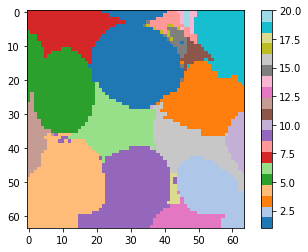

In [193]:
plt.imshow(np.add(segments,1),'Vega20')
plt.colorbar()